In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import time
import h5py
import scipy.sparse as sp

import importlib
from pathlib import Path
import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das
import D2_direct_solver as dds

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)
importlib.reload(dds)

<module 'D2_direct_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_direct_solver.py'>

## This part reads weights information from the matlab data, but regenerate signal from our own understanding

In [43]:
from scipy.stats import multivariate_normal

# The next line reads the weights from the matlab data provided by Haldar.
# It is for 3D spatial space with dimension (5, 38, 28). Each voxel has at most 3 modes (I guess it is 2),
# and the positions of modes are all the same. The difference exists on the weights.
# For the voxel with all three weights equal to zero, mask it as Fasle.
# However, notice two features. First, the weights in one voxel don't sum to 1. So, I will normalize it by myself.
# Second, Haldar et al don't really consider 3D smoothness. That means the 5 slices are totally unrelated, 
# and don't try to build spatial roughness between the 5 slices.

with h5py.File('/Users/xunan/Projects/MaxEnt/Data/Weighted_com_roi_5slice_rewei_final.mat', 'r') as f:
    w = np.rot90(np.array(f['wei_roi']), 2, axes=(2, 3))

# I then need to normalize the weights, make sure that if the summation is non-zero, then the summation must be 1
# But at the first, we need to get the mask
mask = np.zeros(w.shape[1:])
mask[np.sum(w, axis = 0) > 0] = 1
mask = mask.astype(bool)

# Then give the all-three-zero weights a non-zero value
w[:, np.sum(w, axis = 0) == 0] = 1

# And then normalize weights
w = w / np.sum(w, axis = 0)[None, ...]

# This is the acquasition setting of qs parameter
qs = np.loadtxt("/Users/xunan/Documents/MATLAB/DRSuite/data/acq_phantom.txt", delimiter=",")

# The three modes below is given on Haldar's code, see "generate_phantom.m"
D = np.array([1, 0.2, 0.5])             # it was 1, 0.1, 0.5
std_D = np.array([0.05, 0.02, 0.03])    # it was 0.01, 0.0003, 0.005.

T = np.array([60, 70, 25])              # it was 60, 70, 20
std_T = np.array([10, 12, 4])           # it was 10, 15, 10. I changed it because mu-3*std becomes negative 

# Because the std is really small, and the distances between any two modes are really big.
# We will either take Monte Carlo sampling to calculate the integral,
# or we can use local refined grid to calculate the integral of each mode

# Below we still consider quadrature and set thetas for three modes respectively

Sqs = np.zeros((mask.size, qs.shape[0]))

for i in range(3):
    theta1 = np.linspace(D[i] - 5 * std_D[i], D[i] + 5 * std_D[i], 200)
    theta2 = np.linspace(T[i] - 5 * std_T[i], T[i] + 5 * std_T[i], 200) # use -4 to avoid negatives (25/6 = 3.33)
    thetas, weights = bf.Cartesian(theta1, theta2)
    f_thetas = multivariate_normal(mean=np.array([D[i], T[i]]), 
                                   cov=np.array([[std_D[i]**2, 0], [0, std_T[i]**2]])).pdf(thetas)
    f_thetas = np.repeat(f_thetas[None, :], mask.size, axis = 0)

    Sqs = Sqs + (   bf.get_Sqs(bf.kernel(qs, thetas), weights, f_thetas, sigma = 0) * 
                    np.repeat(w[i].ravel()[:, None], qs.shape[0], axis = 1)             )
    
    # the following part is used to output the probabilities on a given grid to be compared witht the recovery
    # so, the theta1 and the theta2 should be consistent with those in inverse problem

    theta1_cmp = np.logspace(np.log10(0.01), np.log10(1.5), 100)
    theta2_cmp = np.logspace(np.log10(1),    np.log10(200), 100)
    thetas_cmp, weights_cmp = bf.Cartesian(theta1_cmp, theta2_cmp) 
    f_true = np.zeros((f_thetas.shape[0], thetas_cmp.shape[0])) if i == 0 else f_true
    f_i = multivariate_normal(  mean=np.array([D[i], T[i]]), 
                                cov=np.array([[std_D[i]**2, 0], [0, std_T[i]**2]])).pdf(thetas_cmp)
    f_i = np.repeat(f_i[None, :], mask.size, axis = 0)
    f_true = f_true + f_i * np.repeat(w[i].ravel()[:, None], f_i.shape[1], axis = 1)

Sqs = Sqs.reshape(mask.shape + (-1,))

# Then we save this as *.pt file to read it on HPC. qs, mask, Sqs are all needed.

# torch.save({'qs': torch.tensor(qs, dtype=torch.float64),
#             'mask': torch.tensor(mask, dtype=torch.bool),
#             'Sqs': torch.tensor(Sqs, dtype=torch.float64),
#             'w': torch.tensor(w, dtype=torch.float64),
#             'f_true': torch.tensor(f_true.reshape((5, 38, 28, -1)), dtype=torch.float64)    },
#             '/Users/xunan/Projects/MaxEnt/Data/Haldar_Noisefree.pt')


In [44]:
# add normal noise to Sqs to generate noisy data
SNR = 10
sigma = np.max(Sqs) / SNR
Sqs = Sqs + np.random.normal(0, sigma, Sqs.shape)

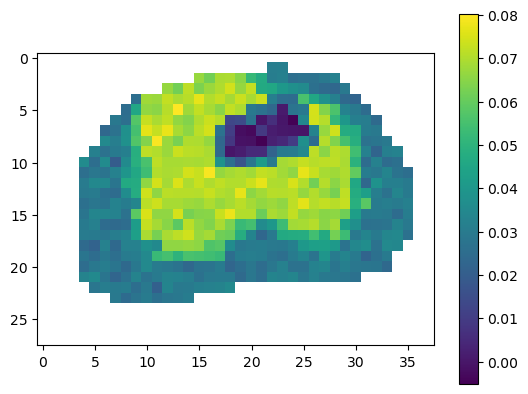

In [45]:
plt.imshow(np.fliplr(np.rot90(np.ma.array(np.mean(Sqs[0, :, :, :], axis = 2), mask=1 - mask[0]))), aspect='equal')
plt.colorbar()
plt.show()

## General inverse

In [46]:
# On personal computer, select a small area (the first slice) to run the algorithm
select_mask = np.zeros_like(mask, dtype=bool)       # all False
select_mask[0, :, :] = True                         # set first slice to True 21:26, 10:15,     5:30, 7:22
mask = mask & select_mask # & remask

lin2idx = bf.mask_to_lin2idx(mask)
print("V = ", np.sum(mask))

V =  586


In [47]:
theta1 = np.logspace(np.log10(0.01), np.log10(1.5), 100)   # 3
theta2 = np.logspace(np.log10(1), np.log10(200), 100)    # 300

thetas, weights = bf.Cartesian(theta1, theta2)

R = rr.R_mask(mask, 49, order = 2)
R0 = sp.csr_matrix(R.shape)

In [48]:
alpha = 0.7
beta = 2000

In [49]:
lambdas, f_hat, history = das.admm( qs, thetas, weights, Sqs[mask, :], sigma = sigma * alpha,
                                    R_csr = R * beta, f0 = None, normalize = True, Lambdas = None, 
                                    beta = 0.5, c = 1e-4, epsilon = 1e-8, tol = 1e-10, maxiter = 1,
                                    cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000,
                                    rho = 0.5, rho_ratio = 2, dynamic_rho = True,
                                    admm_tol = 1e-6, admm_maxiter = 100 )

In [50]:
f_hat_flip = f_hat.reshape((-1, len(theta2), len(theta1)), order = 'F').reshape((-1, len(theta1)*len(theta2)), order = 'C') # (thetas[:, 1]**2)[None, :]

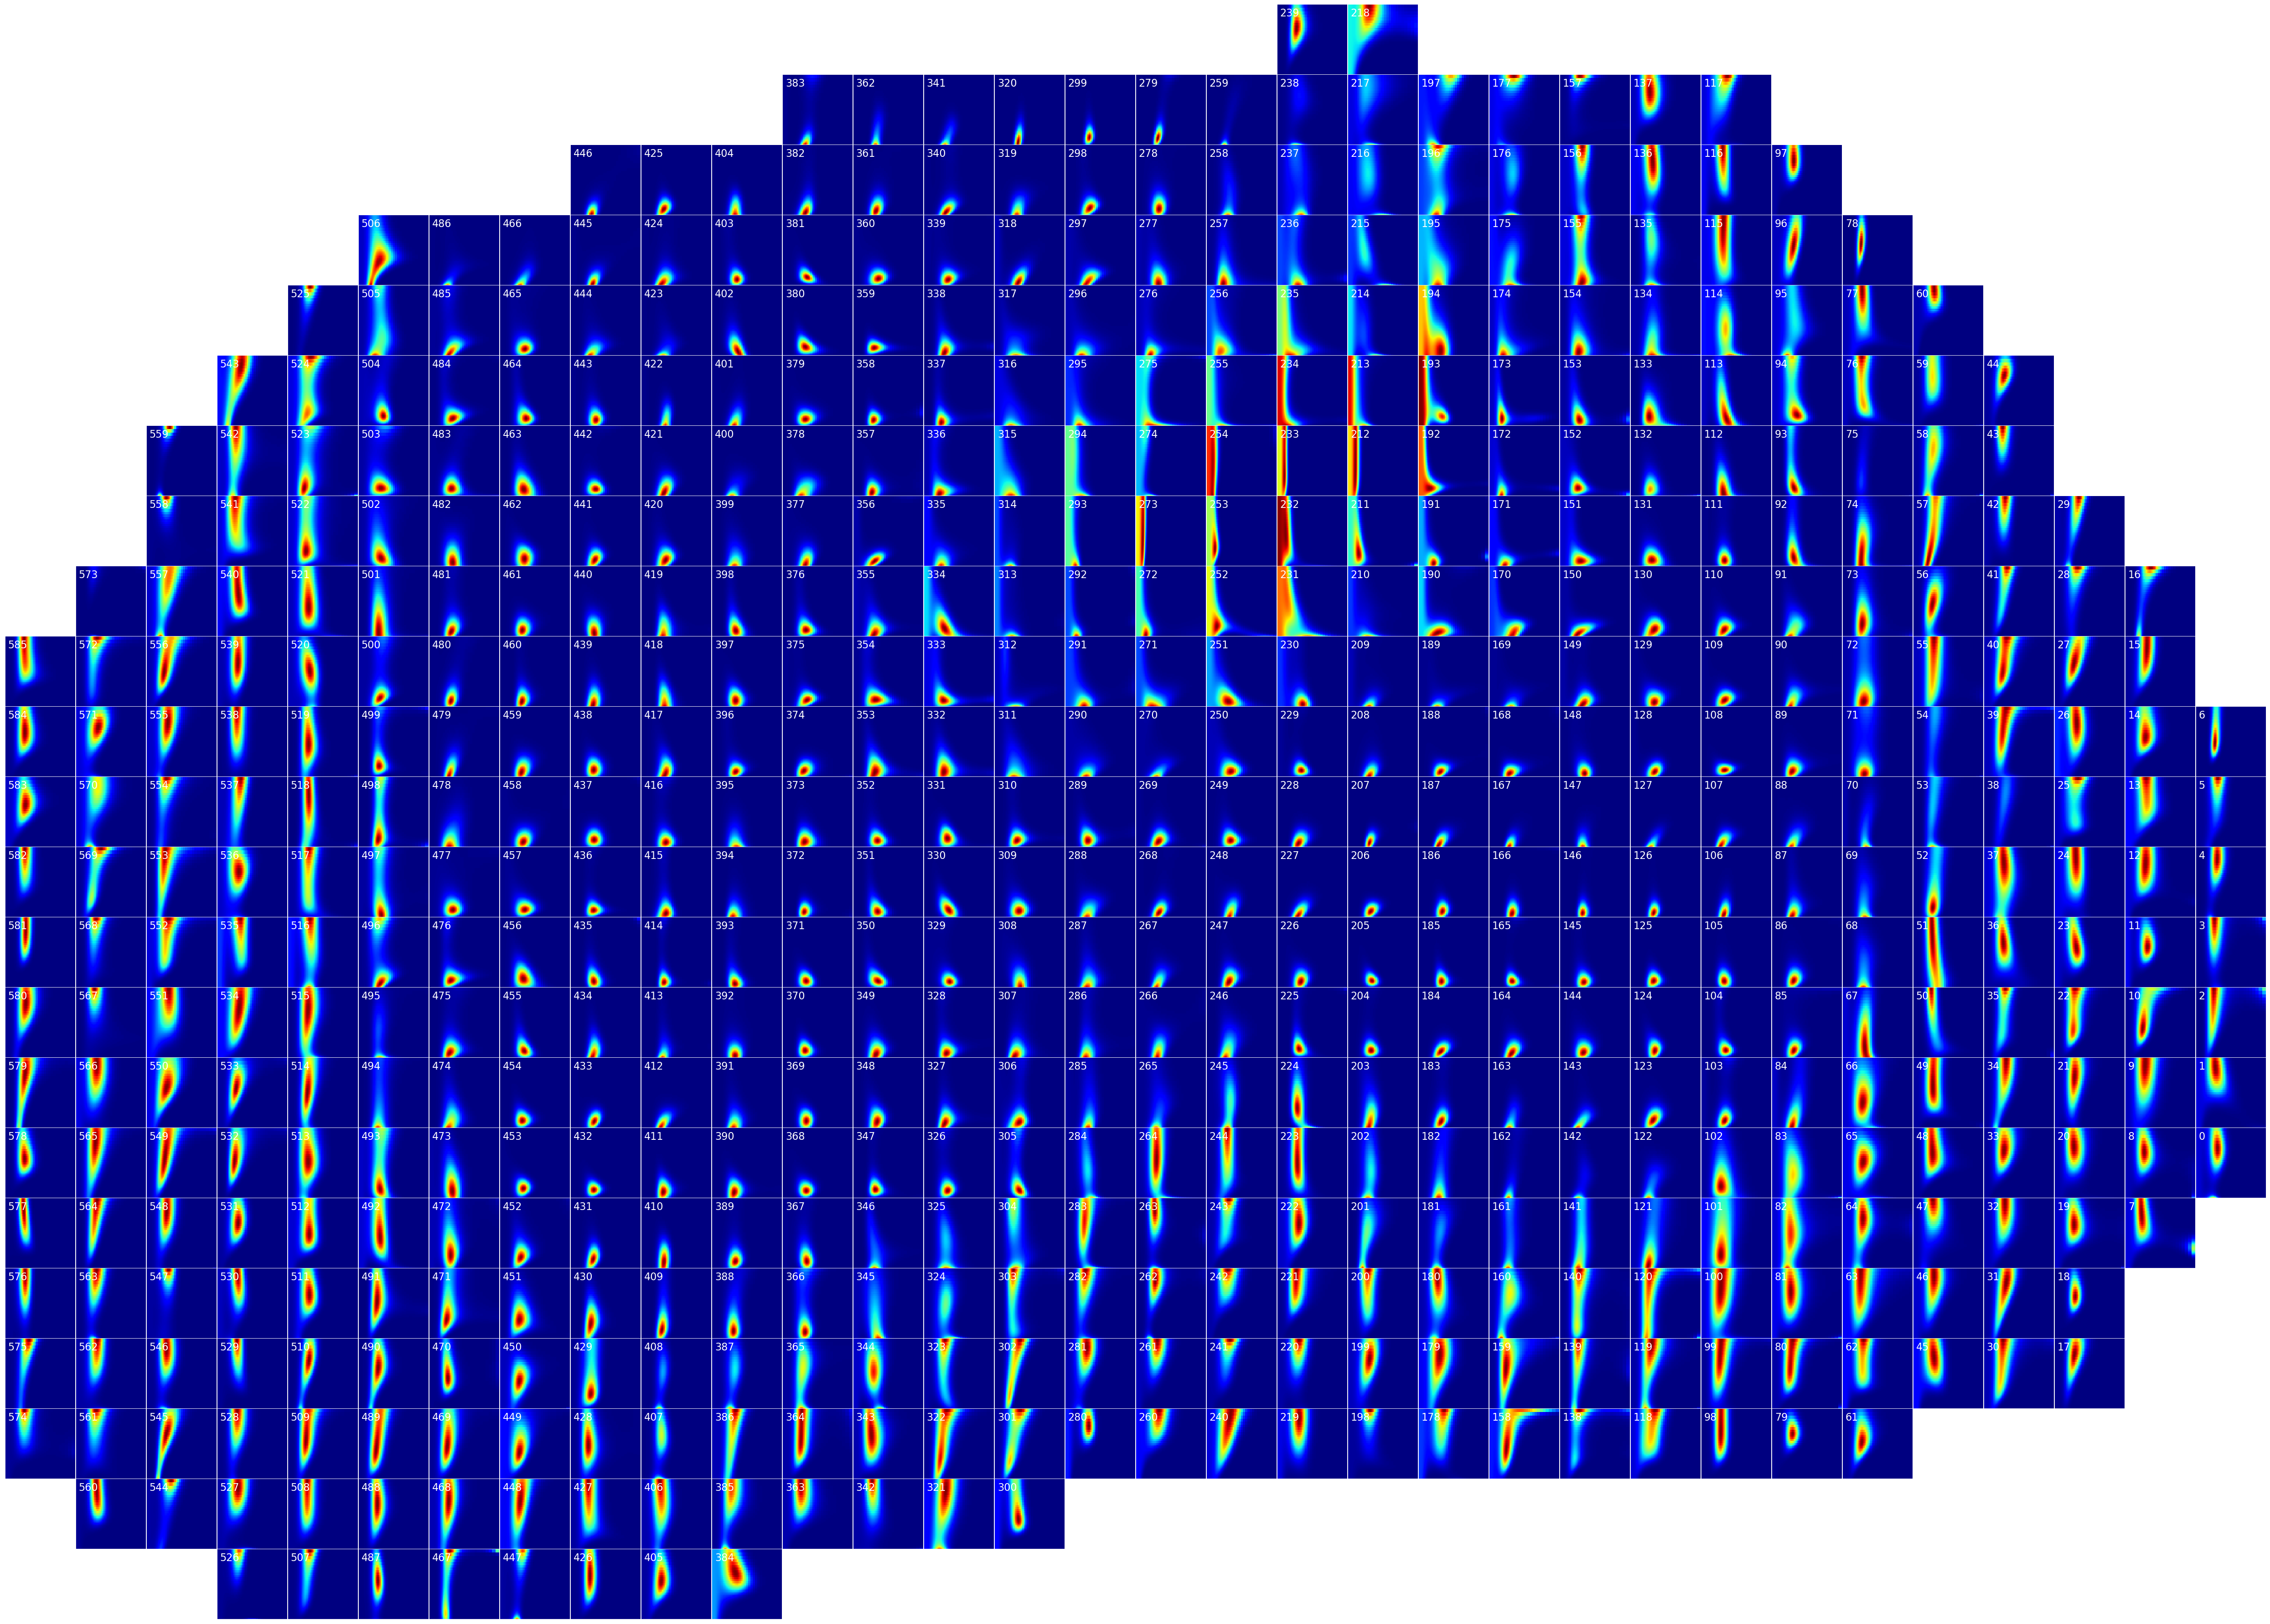

In [51]:
bf.contourf_mask(theta2, theta1, f_hat_flip, lin2idx, axis = 0, slice = 0)

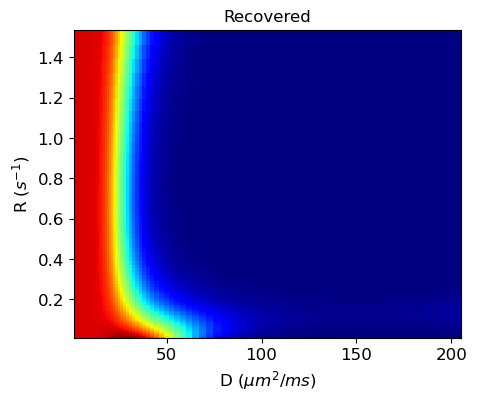

In [52]:
i = 234
bf.contourf_compare(theta2, theta1, f_hat_flip[i, :] )

## UQ


In [54]:
Precision = das.uncertainty(lambdas, qs, thetas, weights, Sqs[mask, :], sigma = sigma * alpha,
                            R_csr = R * beta, f0 = None, normalize = True, 
                            cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000)

In [55]:
lambdas_sample = bf.chol_sample(lambdas, Precision)

In [56]:
f0 = 1/np.sum(weights)*np.ones(f_hat.shape)            # this defines the prior
f_UQ = das.f_thetas_hat(lambdas_sample, bf.kernel(qs, thetas), weights, f0, normalize = True)

In [57]:
f_UQ_flip = f_UQ.reshape((-1, len(theta2), len(theta1)), order = 'F').reshape((-1, len(theta1)*len(theta2)), order = 'C') # (thetas[:, 1]**2)[None, :]

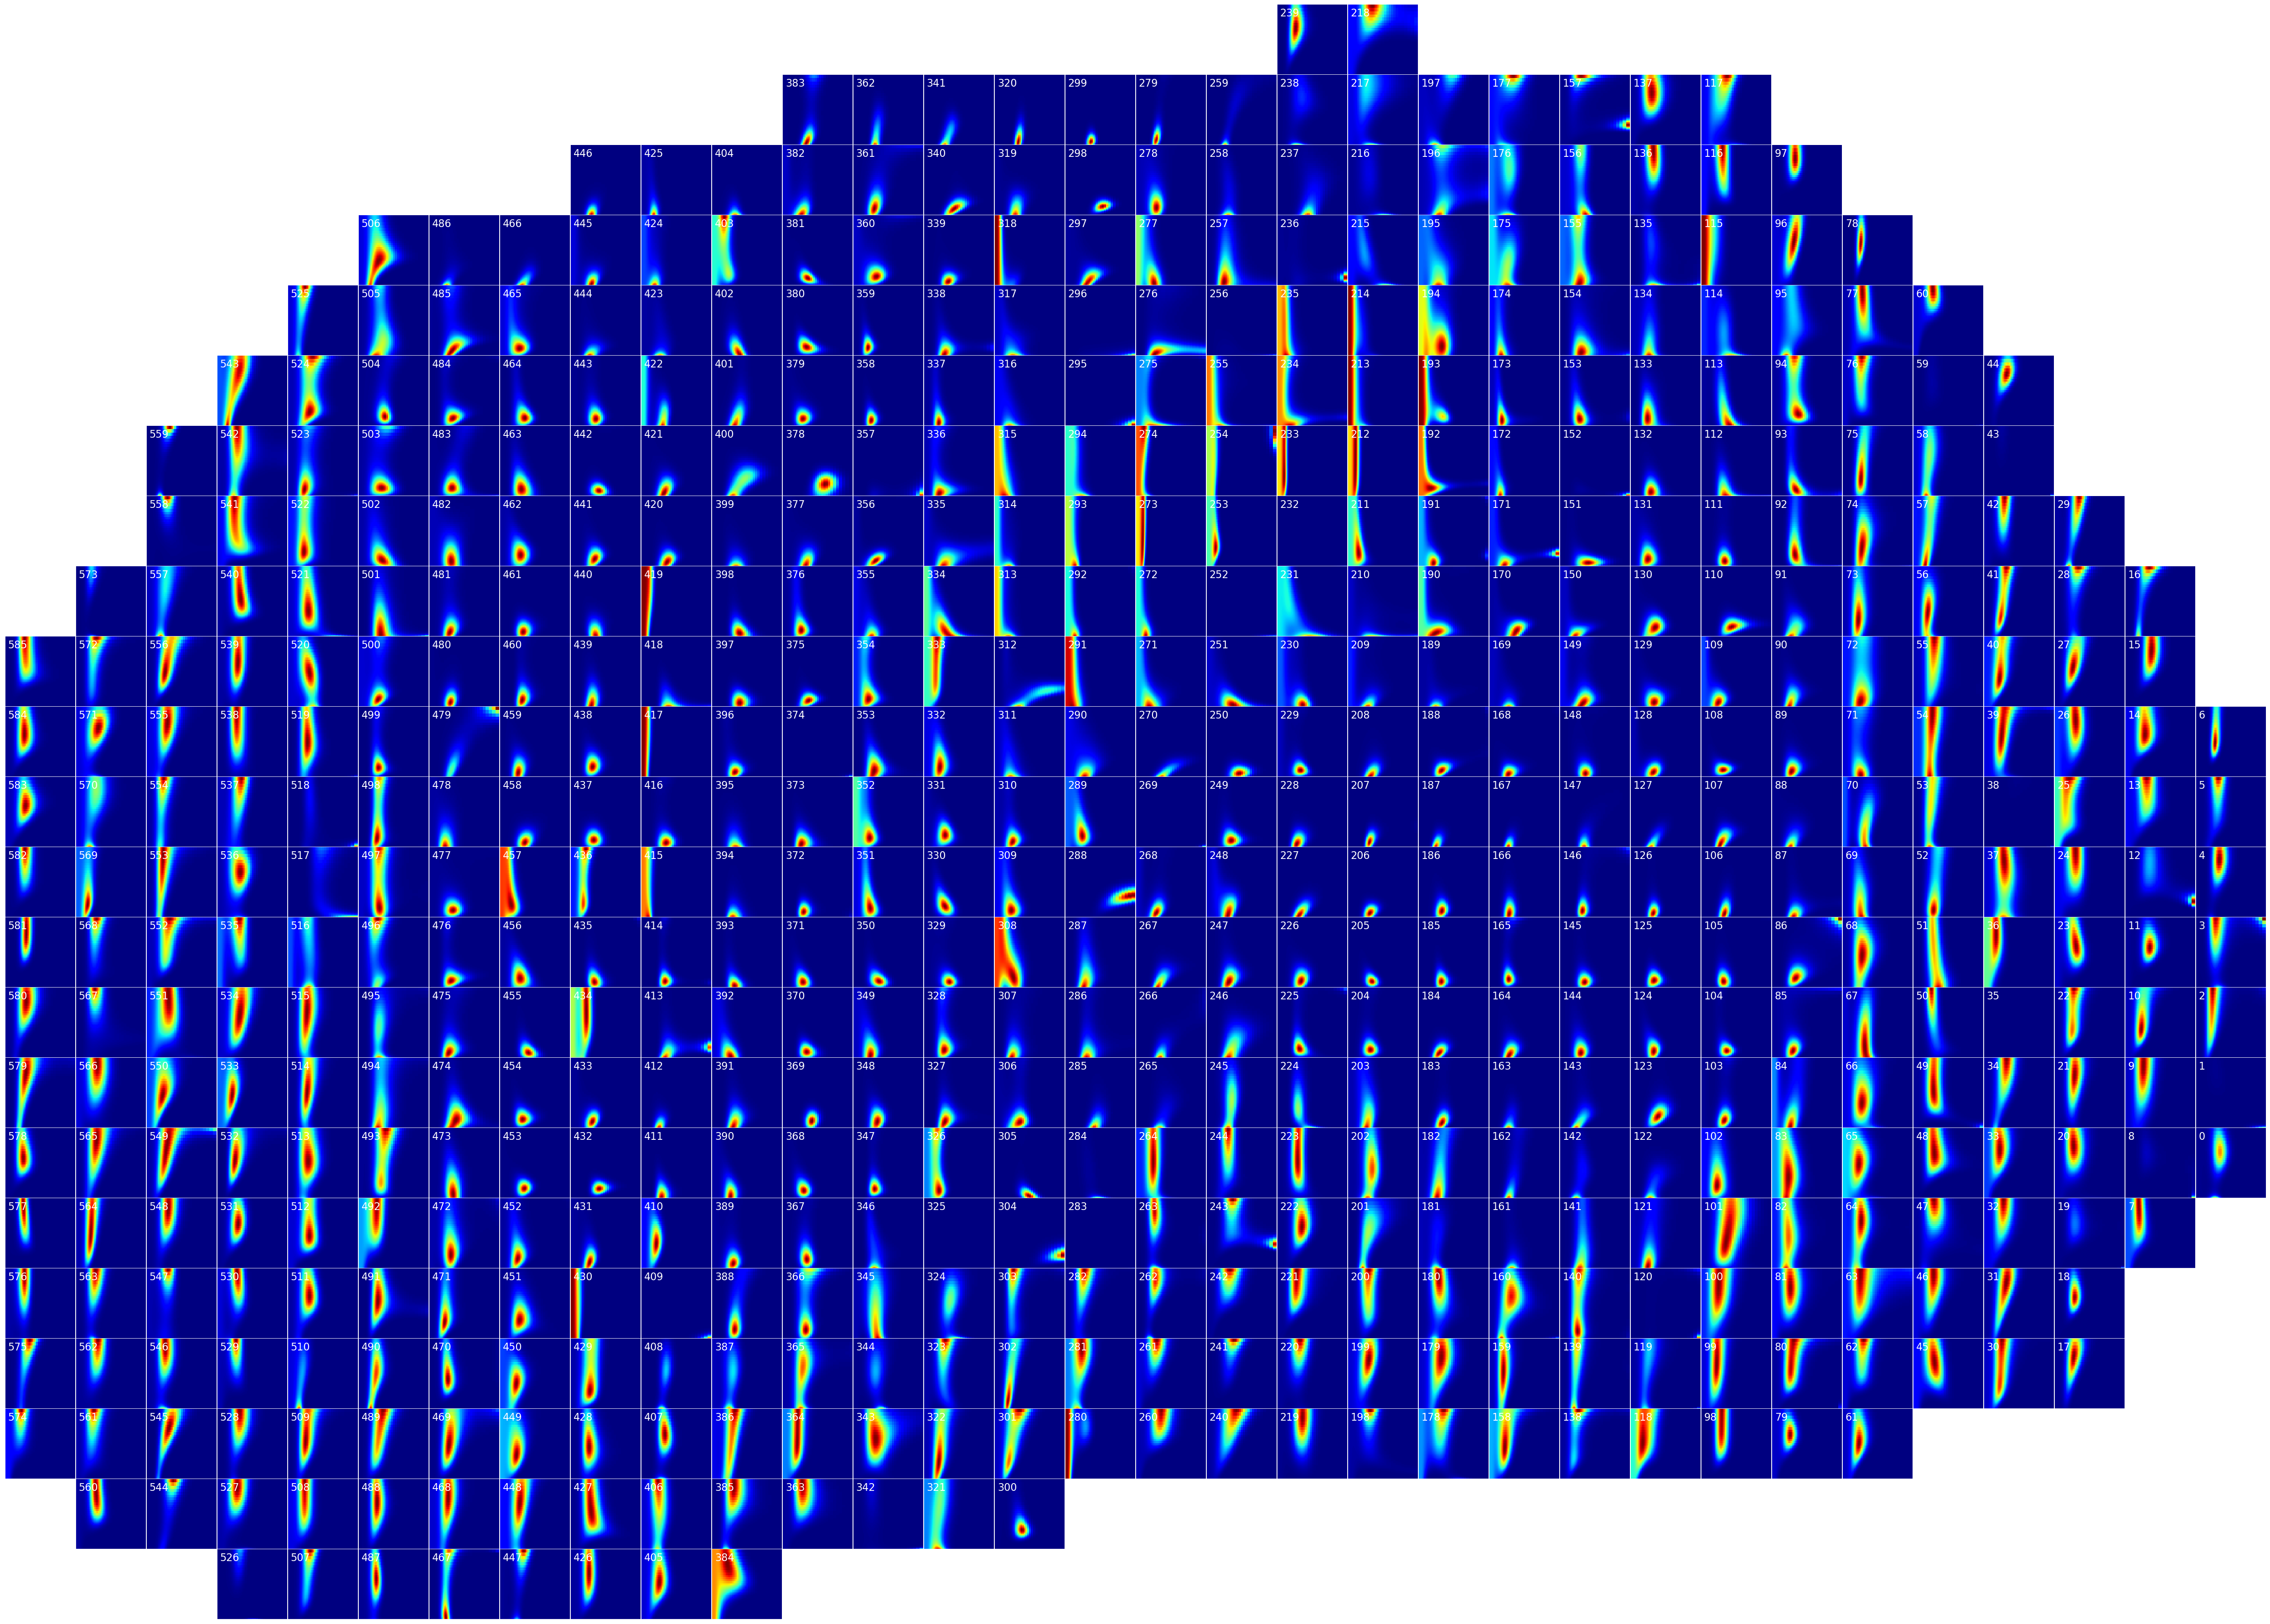

In [58]:
bf.contourf_mask(theta2, theta1, f_UQ_flip, lin2idx, axis = 0, slice = 0)

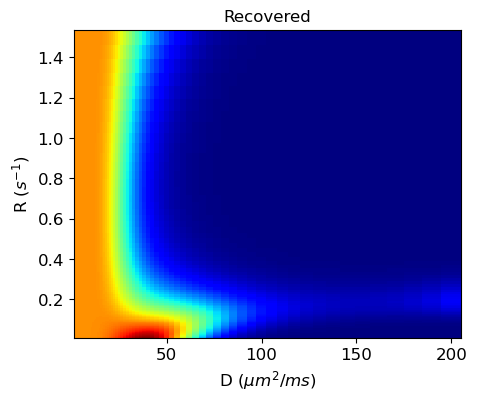

In [59]:
i = 234
bf.contourf_compare(theta2, theta1, f_UQ_flip[i, :] )